# EstraNet Training on Google Colab

This notebook trains the EstraNet Transformer model for side-channel analysis on ASCAD dataset.

**Steps:**
1. Setup environment and clone repository
2. Download/upload ASCAD dataset
3. Train the model
4. Evaluate results

## 1. Setup Environment

In [1]:
# Check GPU availability
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# If no GPU, you can enable it via: Runtime → Change runtime type → GPU

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Clone your repository
!git clone https://github.com/loshithan/EstraNet.git
%cd EstraNet

Cloning into 'EstraNet'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 86 (delta 39), reused 83 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (86/86), 2.81 MiB | 8.29 MiB/s, done.
Resolving deltas: 100% (39/39), done.
/content/EstraNet


In [4]:
# Install dependencies
!pip install -r requirements.txt

## 2. Download ASCAD Dataset

Choose one option below:

In [5]:
import os
import gdown

# Create data directory
os.makedirs('data', exist_ok=True)

# ASCADf dataset configuration
file_id = "1O0acDigSHufPXldDeyiF_jGkjPUyFHSv"
#"1WNajWT0qFbpqPJiuePS_HeXxsCvUHI5M"
DATASET_PATH = "data/ASCAD.h5"

if not os.path.exists(DATASET_PATH):
    print("📥 Downloading ASCADf dataset from Google Drive...")
    print("   This may take a few minutes (~1.5 GB)\n")
    
    # Download using gdown
    gdown.download(f"https://drive.google.com/uc?id={file_id}", DATASET_PATH, quiet=False)
    
    print("\n✅ Dataset downloaded successfully!")
else:
    print("✅ Dataset already exists")

# Verify dataset
import h5py
with h5py.File(DATASET_PATH, 'r') as f:
    print(f"\n📊 Dataset info:")
    print(f"  Keys: {list(f.keys())}")
    if 'Profiling_traces' in f:
        print(f"  Profiling traces shape: {f['Profiling_traces/traces'].shape}")
    if 'Attack_traces' in f:
        print(f"  Attack traces shape: {f['Attack_traces/traces'].shape}")

📥 Downloading ASCADf dataset from Google Drive...
   This may take a few minutes (~1.5 GB)



Downloading...
From: https://drive.google.com/uc?id=1WNajWT0qFbpqPJiuePS_HeXxsCvUHI5M
To: /content/EstraNet/data/ASCAD.h5
100%|██████████| 46.6M/46.6M [00:00<00:00, 70.1MB/s]


✅ Dataset downloaded successfully!

📊 Dataset info:
  Keys: ['Attack_traces', 'Profiling_traces']
  Profiling traces shape: (50000, 700)
  Attack traces shape: (10000, 700)


In [6]:
# Verify dataset
import h5py
import os

if os.path.exists('data/ASCAD.h5'):
    with h5py.File('data/ASCAD.h5', 'r') as f:
        print("✓ ASCAD.h5 found!")
        print("  Available keys:", list(f.keys()))
        print("  Profiling traces shape:", f['Profiling_traces']['traces'].shape)
        print("  Attack traces shape:", f['Attack_traces']['traces'].shape)
else:
    print("✗ ASCAD.h5 not found. Please upload the dataset.")

✓ ASCAD.h5 found!
  Available keys: ['Attack_traces', 'Profiling_traces']
  Profiling traces shape: (50000, 700)
  Attack traces shape: (10000, 700)


## 3. Configure Training

Edit these settings as needed:

In [7]:
# Training configuration
CONFIG = {
    # Paths
    'data_path': 'data/ASCAD.h5',
    'checkpoint_dir': '/content/drive/MyDrive/estranet_checkpoints',  # Save to Google Drive
    'result_path': 'results',
    
    # Training settings (adjusted for Colab)
    'train_steps': 50000,        # Reduced from 4M for faster training
    'warmup_steps': 5000,        # Reduced from 1M
    'save_steps': 5000,          # Save every 5k steps
    'iterations': 1000,          # Log every 1k steps
    'train_batch_size': 32,      # Adjust based on GPU memory
    'eval_batch_size': 32,
    
    # Data settings
    'input_length': 10000,       # Use 10000 for faster training
    'data_desync': 200,          # Data augmentation
    
    # Model architecture
    'n_layer': 2,
    'd_model': 128,
    'd_head': 32,
    'n_head': 8,
    'd_inner': 256,
    'n_head_softmax': 8,
    'd_head_softmax': 16,
    'dropout': 0.05,
    'n_conv_layer': 2,
    'pool_size': 20,
    
    # Optimization
    'learning_rate': 2.5e-4,
    'clip': 0.25,
    'min_lr_ratio': 0.004,
}

# Create checkpoint directory
!mkdir -p {CONFIG['checkpoint_dir']}
!mkdir -p results

print("Configuration ready!")
print(f"Checkpoints will be saved to: {CONFIG['checkpoint_dir']}")

Configuration ready!
Checkpoints will be saved to: /content/drive/MyDrive/estranet_checkpoints


## 4. Train the Model

In [9]:
# Build the training command
train_cmd = f"""
python train_trans.py \
    --data_path={CONFIG['data_path']} \
    --checkpoint_dir={CONFIG['checkpoint_dir']} \
    --dataset=ASCAD \
    --input_length={CONFIG['input_length']} \
    --data_desync={CONFIG['data_desync']} \
    --train_batch_size={CONFIG['train_batch_size']} \
    --eval_batch_size={CONFIG['eval_batch_size']} \
    --train_steps={CONFIG['train_steps']} \
    --warmup_steps={CONFIG['warmup_steps']} \
    --iterations={CONFIG['iterations']} \
    --save_steps={CONFIG['save_steps']} \
    --n_layer={CONFIG['n_layer']} \
    --d_model={CONFIG['d_model']} \
    --d_head={CONFIG['d_head']} \
    --n_head={CONFIG['n_head']} \
    --d_inner={CONFIG['d_inner']} \
    --n_head_softmax={CONFIG['n_head_softmax']} \
    --d_head_softmax={CONFIG['d_head_softmax']} \
    --dropout={CONFIG['dropout']} \
    --conv_kernel_size=3 \
    --n_conv_layer={CONFIG['n_conv_layer']} \
    --pool_size={CONFIG['pool_size']} \
    --d_kernel_map=512 \
    --beta_hat_2=150 \
    --model_normalization=preLC \
    --head_initialization=forward \
    --softmax_attn=True \
    --learning_rate={CONFIG['learning_rate']} \
    --clip={CONFIG['clip']} \
    --min_lr_ratio={CONFIG['min_lr_ratio']} \
    --max_eval_batch=100 \
    --do_train=True
"""

print("Starting training...")
print("="*60)
!{train_cmd}

Starting training...
2026-02-12 09:37:18.782379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770889038.796294    4135 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770889038.800773    4135 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770889038.811497    4135 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770889038.811519    4135 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770889038.811522    4135 computation_placer.cc:177] c

## 5. Monitor Training (Optional)

Run this in a separate cell while training is running:

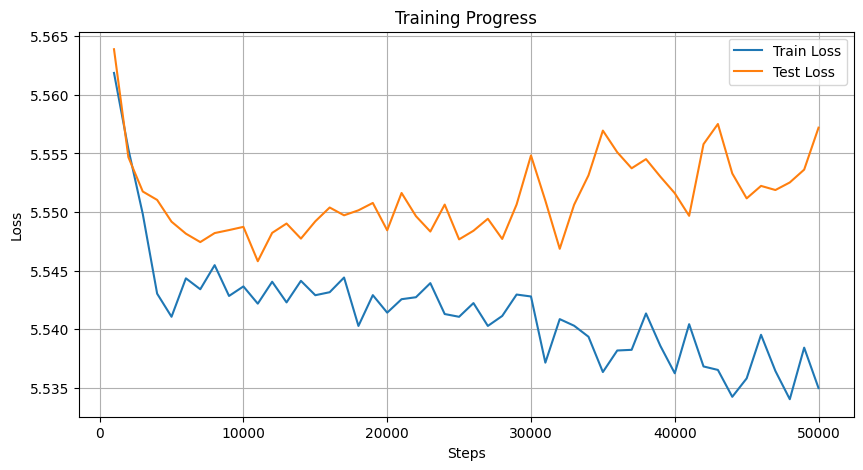

Latest step: 50000
Train loss: 5.5350
Test loss: 5.5572


In [10]:
# View training progress
import pickle
import matplotlib.pyplot as plt

loss_file = f"{CONFIG['checkpoint_dir']}/loss.pkl"

try:
    with open(loss_file, 'rb') as f:
        loss_dict = pickle.load(f)
    
    steps = sorted(loss_dict.keys())
    train_losses = [loss_dict[s]['train_loss'] for s in steps]
    test_losses = [loss_dict[s]['test_loss'] for s in steps]
    
    plt.figure(figsize=(10, 5))
    plt.plot(steps, train_losses, label='Train Loss')
    plt.plot(steps, test_losses, label='Test Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Progress')
    plt.grid(True)
    plt.show()
    
    print(f"Latest step: {steps[-1]}")
    print(f"Train loss: {train_losses[-1]:.4f}")
    print(f"Test loss: {test_losses[-1]:.4f}")
except FileNotFoundError:
    print("Loss file not found yet. Training hasn't started saving checkpoints.")

## 6. Evaluate the Model

In [12]:
import os
import shutil

# Source: Google Drive checkpoint directory
gdrive_checkpoint_dir = '/content/drive/MyDrive/estranet_checkpoints'

# Destination: Local checkpoint directory
local_checkpoint_dir = './checkpoints'

# Create local checkpoint directory if it doesn't exist
os.makedirs(local_checkpoint_dir, exist_ok=True)

# Check if checkpoints exist in Google Drive
if os.path.exists(gdrive_checkpoint_dir):
    print(f"📥 Copying checkpoints from Google Drive...")
    print(f"   Source: {gdrive_checkpoint_dir}")
    print(f"   Destination: {local_checkpoint_dir}\n")
    
    # List all files in Google Drive checkpoint directory
    files = os.listdir(gdrive_checkpoint_dir)
    
    # Copy each file (checkpoint files start with 'trans_long')
    checkpoint_files = [f for f in files if f.startswith('trans_long') or f == 'checkpoint' or f == 'loss.pkl']
    
    if checkpoint_files:
        for filename in checkpoint_files:
            src = os.path.join(gdrive_checkpoint_dir, filename)
            dst = os.path.join(local_checkpoint_dir, filename)
            
            if os.path.isfile(src):
                shutil.copy2(src, dst)
                file_size = os.path.getsize(src) / (1024 * 1024)  # Convert to MB
                print(f"  ✓ Copied: {filename} ({file_size:.2f} MB)")
        
        print(f"\n✅ Checkpoints copied successfully!")
        print(f"   Total files: {len(checkpoint_files)}")
    else:
        print("⚠️  No checkpoint files found in Google Drive.")
        print("   Make sure you've trained the model first.")
else:
    print(f"⚠️  Google Drive checkpoint directory not found: {gdrive_checkpoint_dir}")
    print("   Make sure you've mounted Google Drive and trained the model.")

# List local checkpoints
print("\n📂 Local checkpoints:")
!ls -lh {local_checkpoint_dir}

📥 Copying checkpoints from Google Drive...
   Source: /content/drive/MyDrive/estranet_checkpoints
   Destination: ./checkpoints

  ✓ Copied: trans_long-1.data-00000-of-00001 (0.00 MB)
  ✓ Copied: trans_long-1.index (0.00 MB)
  ✓ Copied: checkpoint (0.00 MB)
  ✓ Copied: loss.pkl (0.00 MB)
  ✓ Copied: trans_long-2.data-00000-of-00001 (4.08 MB)
  ✓ Copied: trans_long-2.index (0.01 MB)
  ✓ Copied: trans_long-3.data-00000-of-00001 (4.08 MB)
  ✓ Copied: trans_long-3.index (0.01 MB)
  ✓ Copied: trans_long-4.data-00000-of-00001 (4.08 MB)
  ✓ Copied: trans_long-4.index (0.01 MB)
  ✓ Copied: trans_long-5.data-00000-of-00001 (4.08 MB)
  ✓ Copied: trans_long-5.index (0.01 MB)
  ✓ Copied: trans_long-6.data-00000-of-00001 (4.08 MB)
  ✓ Copied: trans_long-6.index (0.01 MB)
  ✓ Copied: trans_long-7.data-00000-of-00001 (4.08 MB)
  ✓ Copied: trans_long-7.index (0.01 MB)
  ✓ Copied: trans_long-8.data-00000-of-00001 (4.08 MB)
  ✓ Copied: trans_long-8.index (0.01 MB)
  ✓ Copied: trans_long-9.data-00000-of-

In [ ]:
# ============================================================================
# EVALUATION WITH FIXED CHECKPOINT LOADING
# ============================================================================

print("📊 Running Evaluation with Checkpoint Fix\n")
print("="*70)

import tensorflow as tf
import numpy as np
import h5py
import os
from transformer import Transformer
from evaluation_utils import compute_key_rank

# Load data
print("Loading attack traces...")
with h5py.File('data/ASCAD.h5', 'r') as f:
    traces = f['Attack_traces']['traces'][:, :10000]
    labels = f['Attack_traces']['labels'][()]
    plaintexts = f['Attack_traces']['metadata'][:, 0]
    keys = f['Attack_traces']['metadata'][:, 2]

print(f"✅ Loaded {len(traces)} attack traces")

# Create model with EXACT training parameters
print("\nBuilding model...")
model = Transformer(
    n_layer=2, d_model=128, d_head=32, n_head=8, d_inner=256,
    d_head_softmax=16, n_head_softmax=8, dropout=0.05,
    n_classes=256, conv_kernel_size=3, n_conv_layer=2, pool_size=20,
    d_kernel_map=512, beta_hat_2=150, model_normalization='preLC',
    head_initialization='forward', softmax_attn=True, output_attn=False
)

# BUILD the model first (this is the key fix!)
print("Building model graph...")
dummy_input = tf.zeros((1, 10000, 1))
_ = model(dummy_input, training=False)
print(f"✅ Model built. Parameters: {model.count_params():,}")

# Load checkpoint - try checkpoint 11 first
checkpoint_idx = 11
checkpoint_path = f'./checkpoints/trans_long-{checkpoint_idx}'
print(f"\nLoading checkpoint: {checkpoint_path}")

checkpoint = tf.train.Checkpoint(model=model)
try:
    checkpoint.restore(checkpoint_path)
    print("✅ Checkpoint loaded!")
except:
    print(f"❌ Failed to load checkpoint {checkpoint_idx}, trying checkpoint 8...")
    checkpoint_idx = 8
    checkpoint_path = f'./checkpoints/trans_long-{checkpoint_idx}'
    checkpoint.restore(checkpoint_path)
    print(f"✅ Checkpoint {checkpoint_idx} loaded!")

# Run inference
print("\nRunning inference...")
traces_expanded = np.expand_dims(traces, axis=-1).astype(np.float32)
predictions = model.predict(traces_expanded, batch_size=32, verbose=1)
print(f"✅ Predictions shape: {predictions.shape}")

# Compute key ranks
print("\nComputing key ranks...")
key_ranks = compute_key_rank(predictions, plaintexts, keys)

# Display results
print("\n" + "="*70)
print("KEY RANK RESULTS (Checkpoint {})".format(checkpoint_idx))
print("="*70)

for n in [10, 50, 100, 200, 500, 1000, 2000, 5000]:
    if n < len(key_ranks):
        rank = key_ranks[n-1]
        status = "✅ RECOVERED!" if rank == 0 else ""
        print(f"  {n:5d} traces: Rank {rank:3d}  {status}")

if 0 in key_ranks:
    first = np.where(key_ranks == 0)[0][0] + 1
    print(f"\n🎉 Key first recovered with {first} traces!")
else:
    print(f"\n⚠️  Key not recovered. Best rank: {np.min(key_ranks)}")

# Save and plot
os.makedirs('results', exist_ok=True)
np.save(f'results/key_ranks_ckpt{checkpoint_idx}.npy', key_ranks)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(key_ranks)
plt.xlabel('Number of Traces')
plt.ylabel('Key Rank')
plt.title(f'Key Rank vs Number of Traces (Checkpoint {checkpoint_idx})')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

📊 Running Evaluation with Checkpoint Fix

Loading attack traces...


ValueError: 2 indexing arguments for 1 dimensions

In [15]:
# Run evaluation to get key rank
eval_cmd = f"""
python train_trans.py \
    --data_path=data/ASCAD.h5 \
    --checkpoint_dir=./checkpoints \
    --dataset=ASCAD \
    --input_length=10000 \
    --eval_batch_size=32 \
    --n_layer=2 \
    --d_model=128 \
    --d_head=32 \
    --n_head=8 \
    --d_inner=256 \
    --n_head_softmax=8 \
    --d_head_softmax=16 \
    --dropout=0.05 \
    --conv_kernel_size=3 \
    --n_conv_layer=2 \
    --pool_size=20 \
    --d_kernel_map=512 \
    --beta_hat_2=150 \
    --model_normalization=preLC \
    --head_initialization=forward \
    --softmax_attn=True \
    --result_path=results/eval_results \
    --do_train=False
"""

print("Starting evaluation...")
!{eval_cmd}

Starting evaluation...
2026-02-12 10:06:56.989374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770890817.002768   15212 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770890817.007142   15212 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770890817.017382   15212 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770890817.017412   15212 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770890817.017415   15212 computation_placer.cc:177]

In [16]:
# Plot key rank results
import numpy as np
import matplotlib.pyplot as plt

results_file = f"{CONFIG['result_path']}/eval_results.txt"

try:
    with open(results_file, 'r') as f:
        lines = f.readlines()
    
    # Last line contains mean ranks
    mean_ranks = np.array([float(x) for x in lines[-1].strip().split()])
    
    plt.figure(figsize=(12, 6))
    plt.plot(mean_ranks)
    plt.xlabel('Number of Traces')
    plt.ylabel('Key Rank')
    plt.title('Key Recovery Performance')
    plt.grid(True)
    plt.yscale('log')
    plt.show()
    
    # Find how many traces needed for rank 0
    rank_0_idx = np.where(mean_ranks == 0)[0]
    if len(rank_0_idx) > 0:
        print(f"✓ Key recovered with {rank_0_idx[0]} traces!")
    else:
        print(f"Key not fully recovered. Best rank: {int(mean_ranks[-1])}")
        
except FileNotFoundError:
    print("Results file not found. Run evaluation first.")

Results file not found. Run evaluation first.


## Tips

1. **Training Time**: With the default config (50k steps), training takes ~2-4 hours on Colab GPU
2. **Checkpoints**: Saved to Google Drive, so they persist across sessions
3. **Resume Training**: Set `--warm_start=True` to resume from last checkpoint
4. **Experiment**: Try different `input_length` (700, 10000, 40000) and model sizes
5. **Memory Issues**: Reduce `train_batch_size` if you get OOM errors